# Data Cleaning - Players Teams

In [1]:
import pandas as pd
from utils import *
import os

df = pd.read_csv('../data/players_teams.csv')

init_num_rows = df.shape[0]

print(f"Num rows: {df.shape[0]}")
print(f"Num cols: {df.shape[1]}")

df.head()

Num rows: 1876
Num cols: 43


,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ
0,abrossv01w,2,0,MIN,WNBA,26,23,846,343,43,...,0,0,0,0,0,0,0,0,0,0
1,abrossv01w,3,0,MIN,WNBA,27,27,805,314,45,...,0,0,0,0,0,0,0,0,0,0
2,abrossv01w,4,0,MIN,WNBA,30,25,792,318,44,...,1,8,8,22,6,8,8,7,3,0
3,abrossv01w,5,0,MIN,WNBA,22,11,462,146,17,...,2,3,7,23,8,4,2,8,2,0
4,abrossv01w,6,0,MIN,WNBA,31,31,777,304,29,...,0,0,0,0,0,0,0,0,0,0


## Dealing with Missing Values / Features

<Axes: title={'center': 'Number of null values per column'}>

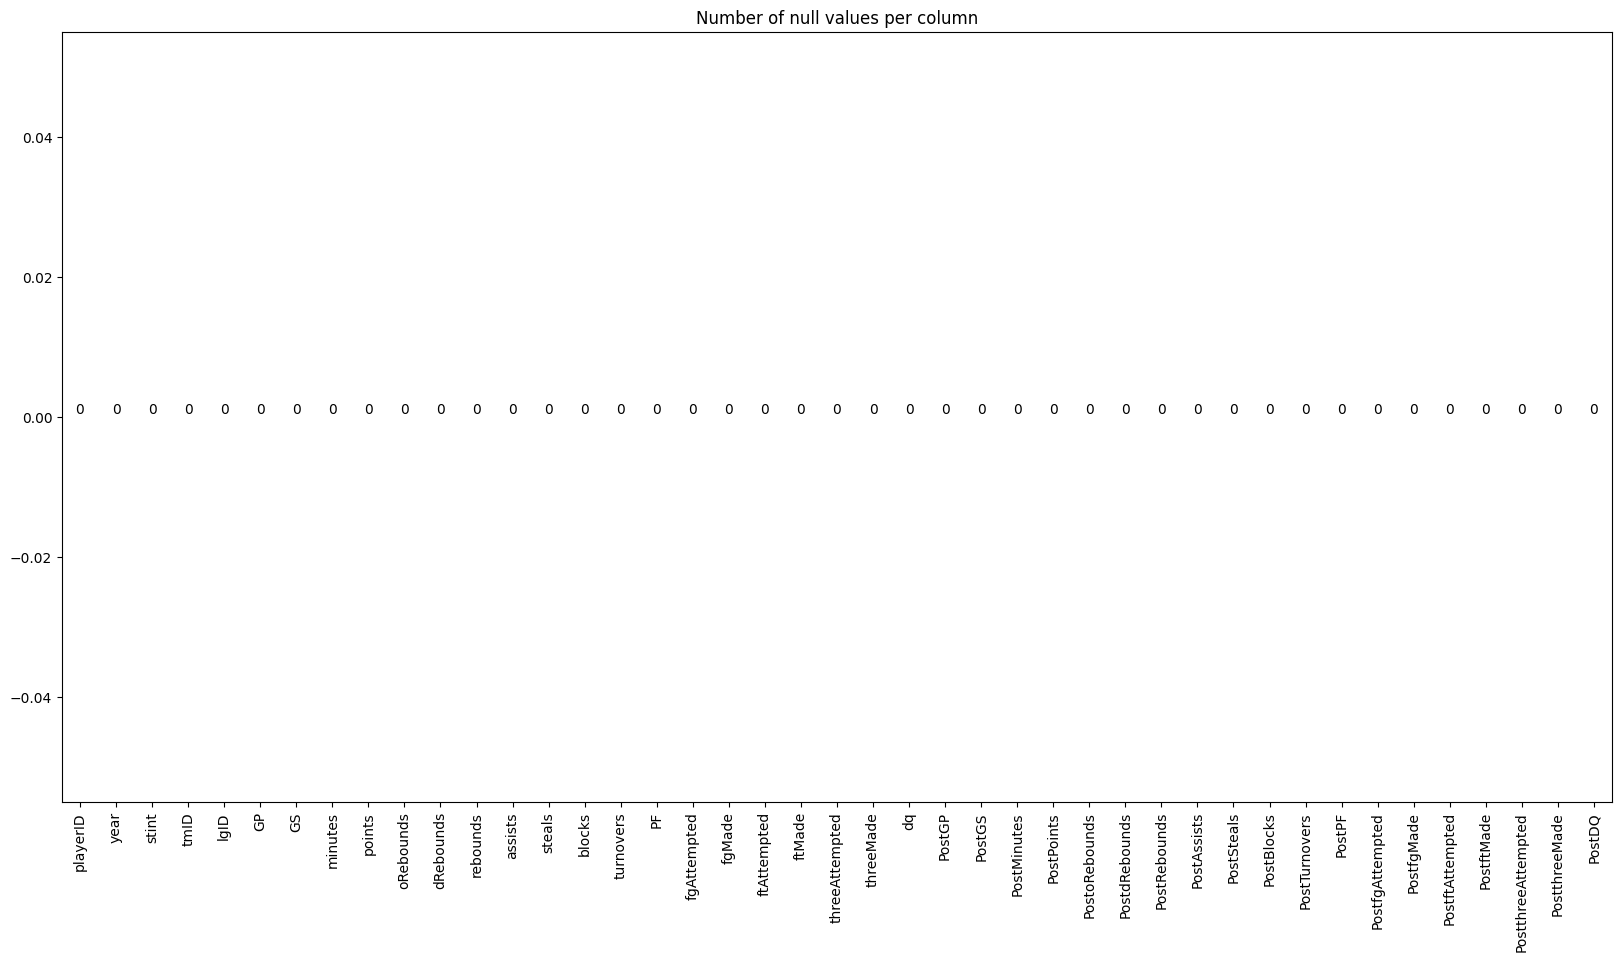

In [2]:
nulls_values_by_column(df, (20, 10))

## Dealing with Duplicate values / Redundant Data

<Axes: title={'center': 'Number of Unique Values Per Column'}>

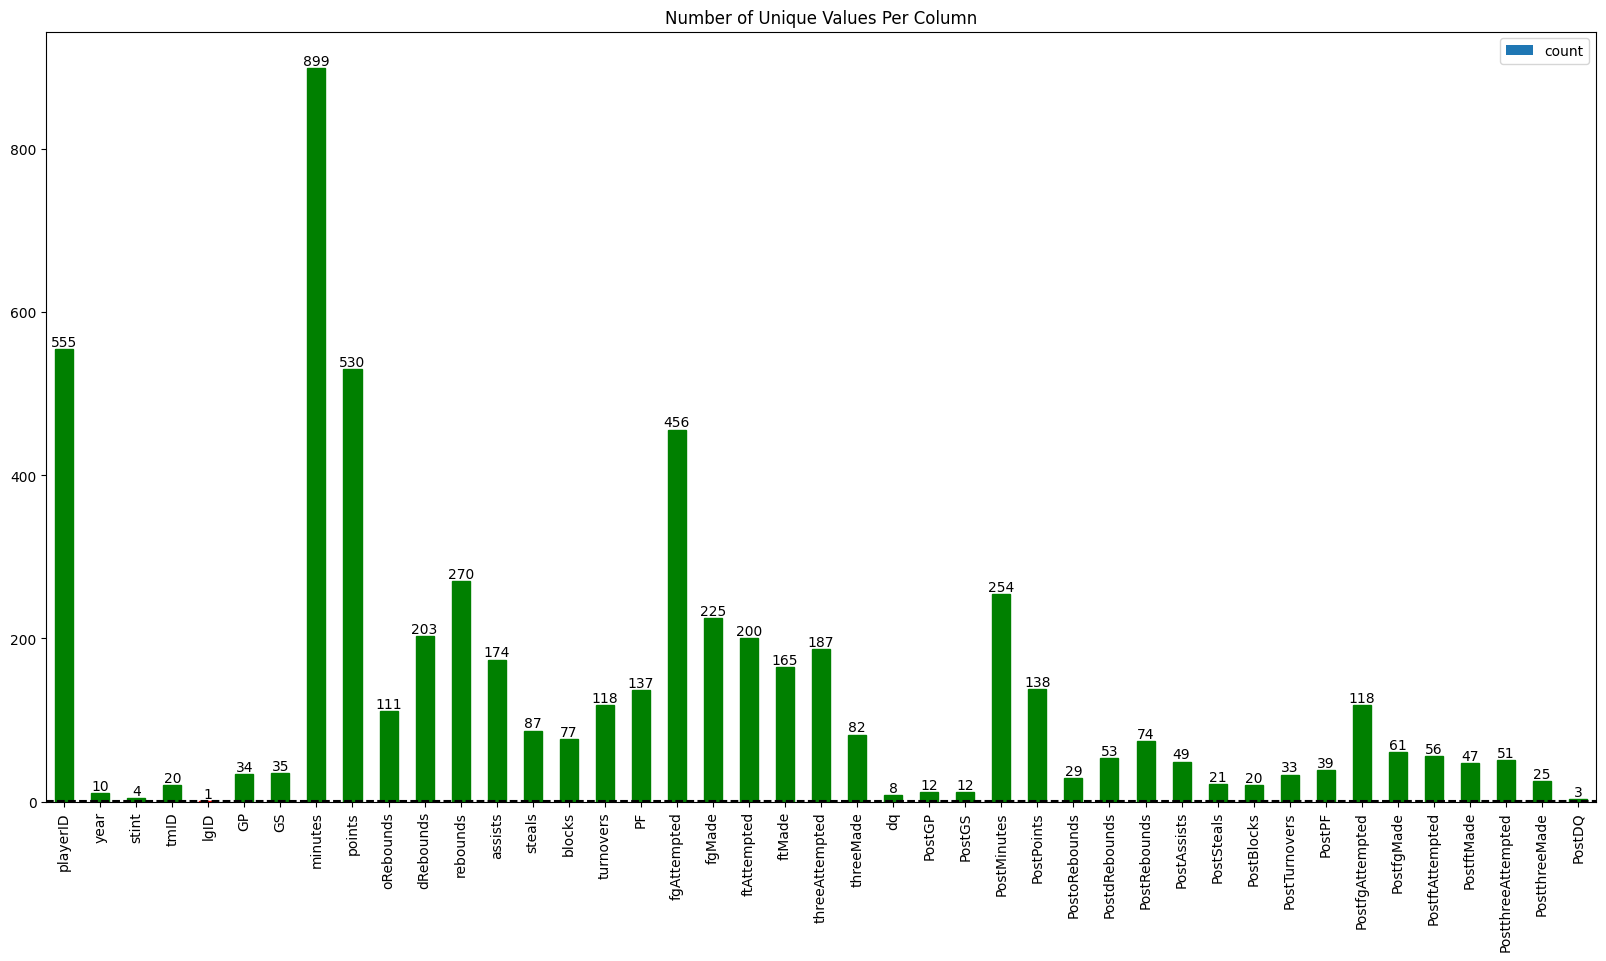

In [3]:
unique_values_by_column(df, 1, (20,10))

In [4]:
num_columns = len(df.columns)
df = filter_column_uniques(df, 1)
print(f"Removed {num_columns - len(df.columns)} columns that had only one unique value")

Removed 1 columns that had only one unique value


In [5]:
num_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {num_rows - df.shape[0]} repeated rows")

Removed 0 repeated rows


## Outliers and Noise

### Detecting and Removing Outliers using ...

### ... z-score

This is a simple way to detect outliers using the z-score. The z-score is the number of standard deviations away from the mean a data point is. If the absolute value of the z-score is greater than 3, we can flag this data point as an outlier.

Let's take a look at the z-score range using a histogram plot.

<module 'matplotlib.pyplot' from '/home/daniel/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

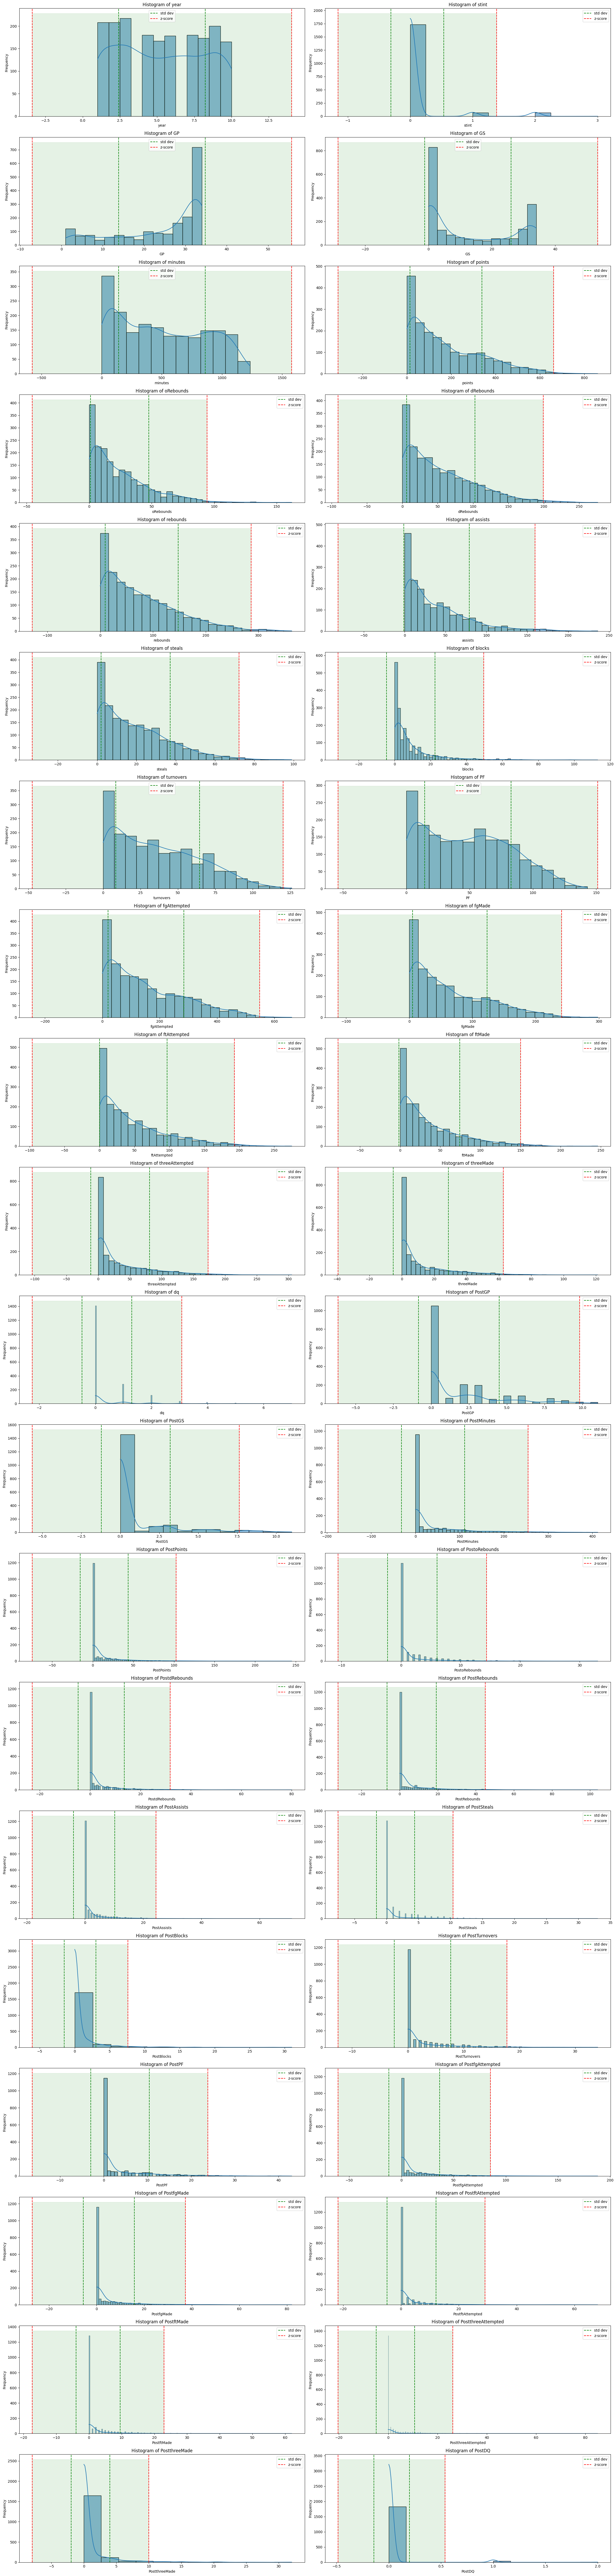

In [6]:
max_zscore = 3
rows2drop = set()
histogram_plot(df, max_zscore, (24, 100))

Now let's use the z-score to detect and remove outliers from the dataset.

In [7]:
rows2drop_zscore = filter_by_zscore(df, max_zscore)
print(f"Removed {len(rows2drop_zscore)} rows with zscore > {max_zscore}")

rows2drop.update(rows2drop_zscore)

Removed 400 rows with zscore > 3


### ... Interquartile Range (IQR)

The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles. It is represented by the formula IQR = Q3 − Q1. The IQR may also be called the midspread or middle 50%. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

Let's take a look at the IQR range using a histogram plot.

<module 'matplotlib.pyplot' from '/home/daniel/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

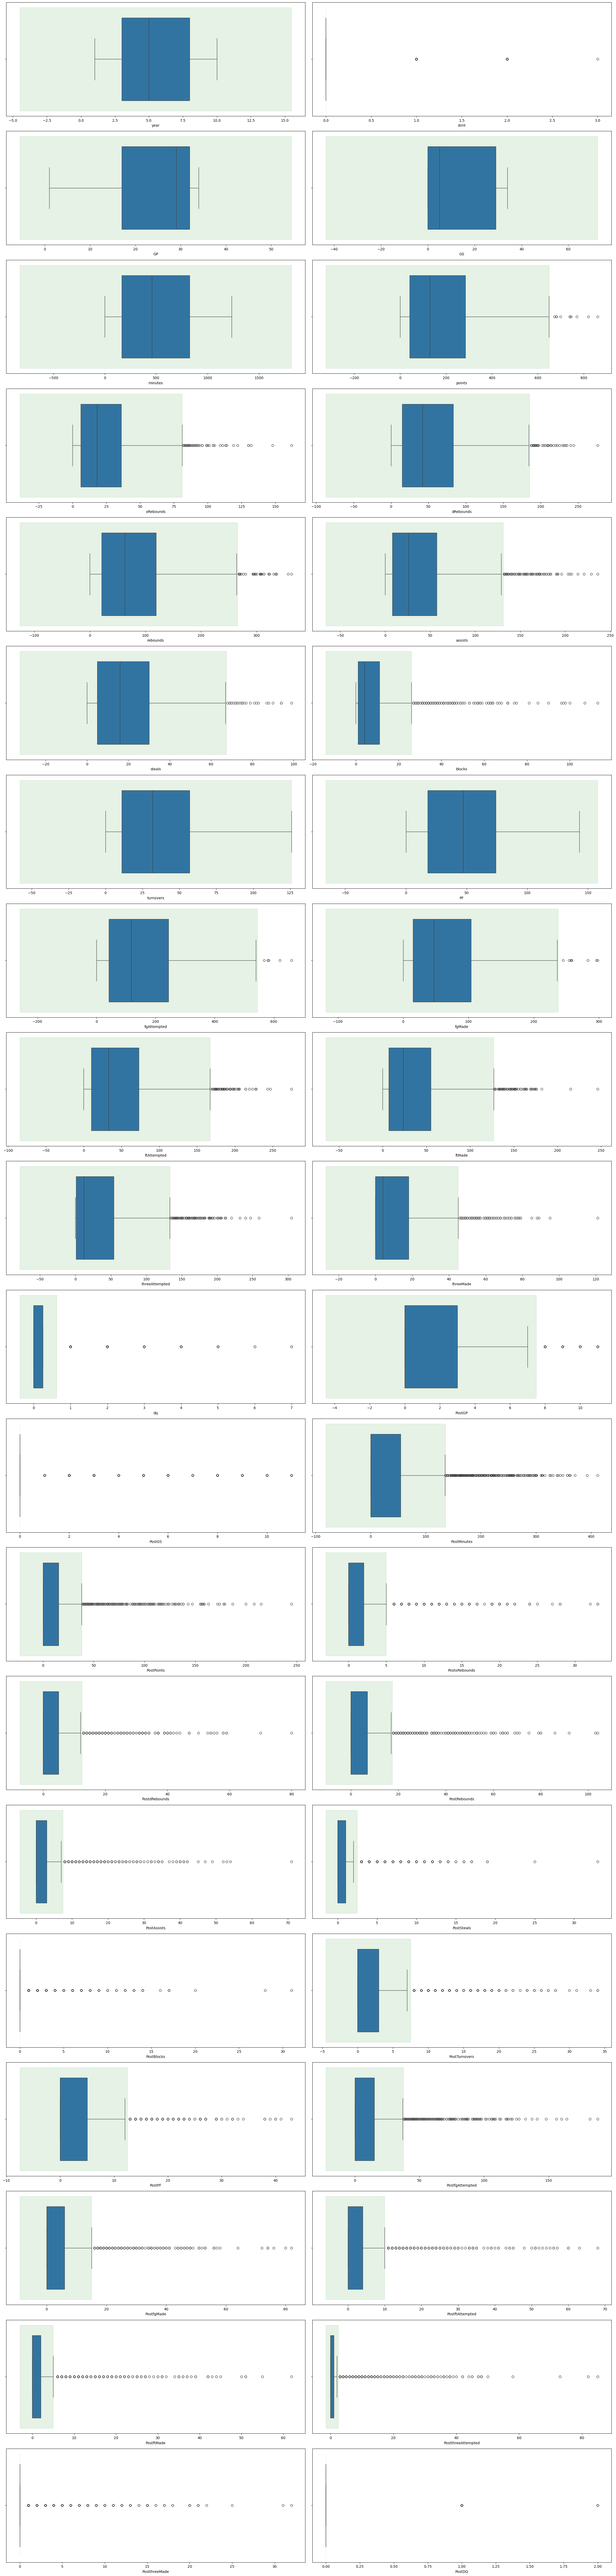

In [8]:
factor = 1.5
iqr_plot(df, factor, (24, 100))

Now let's use the IQR to detect and remove outliers from the dataset.

In [9]:
rows2drop_iqr = filter_by_iqr(df, factor)
print(f"Removed {len(rows2drop_iqr)} rows with factor = {factor}")

rows2drop.update(rows2drop_iqr)

Removed 1085 rows with factor = 1.5


### ... Scatter Plot

In [10]:
#scatter_plot(df.drop(rows2drop))

In [11]:
print(f"Founded {len(rows2drop)} ({round(len(rows2drop) / df.shape[0] * 100, 1)}%) outliers")
#df.drop(rows2drop, axis = 0, inplace=True)
print(f"Removed {init_num_rows - df.shape[0]} rows ({round((init_num_rows - df.shape[0]) / init_num_rows * 100, 1)}%)")

Founded 1085 (57.8%) outliers
Removed 0 rows (0.0%)


## Save Dataset

In [12]:
if not os.path.exists('../data_clean'):
    os.makedirs('../data_clean')

df.to_csv('../data_clean/players_teams.csv', index=False)